In [3]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import random
random.seed(42)

<h1>1 Pregled skupa podataka</h1>

In [4]:
df = pd.read_csv("tweet_data.csv")

In [5]:
print(len(df))

18727


In [6]:
df.sample(10)

,textID,tweet_text,sentiment
1733,1958092948,never did sleep last night feeling horrible t...,negative
3422,1961541371,@AutismInsights laundry instead of sitting her...,negative
11397,1694812799,fun on facebook.,positive
5517,1963318283,Aaahhh I'm just so busy. Sorry everyone.,negative
104,1957012535,@DymeDiva23 Nite. Now I'm up n bored as oppose...,negative
10447,1694367116,"@helenotway yes, it will finish at 7:30 tonigh...",positive
7063,1964697636,@TomFelton it wasn't that good tonight I know...,negative
5854,1963567548,this week of mine was not easy! but finally i...,negative
3489,1961573756,I'm off to a fun filled evening at a funeral h...,positive
14691,1752019908,"Joining facebeek. What a loser, I have no fri...",negative


<h2>1.3 Vizuelizacija podataka</h2>

In [7]:
import matplotlib.pyplot as plt

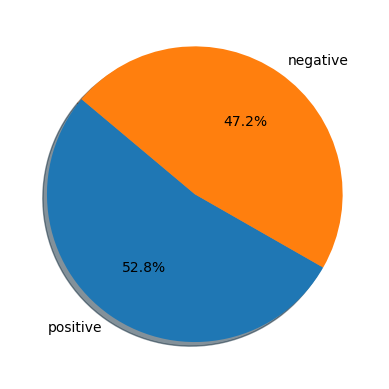

In [8]:
sentiment_count = df["sentiment"].value_counts()
plt.pie(sentiment_count, labels=sentiment_count.index,
        autopct="%1.1f%%", shadow=True, startangle=140)
plt.show()

In [9]:
from wordcloud import WordCloud

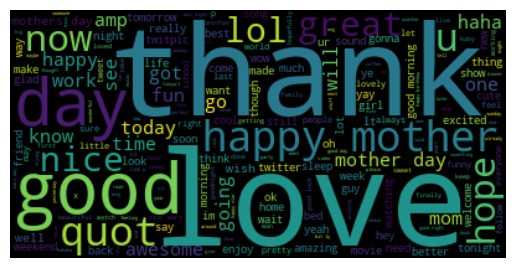

In [10]:
pos_tweets = df[df["sentiment"]=="positive"]
txt = " ".join(tweet.lower() for tweet in pos_tweets["tweet_text"])
wordcloud = WordCloud().generate(txt)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

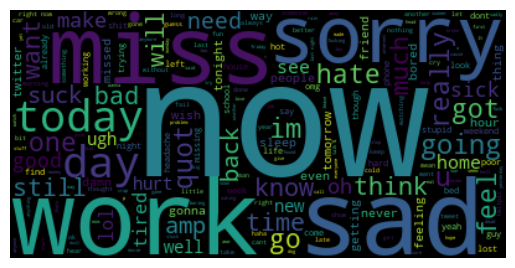

In [11]:
neg_tweets = df[df["sentiment"]=="negative"]
txt = " ".join(tweet.lower() for tweet in neg_tweets["tweet_text"])
wordcloud = WordCloud().generate(txt)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<h1>2 Normalizacija teksta</h1>

In [12]:
import re

<h2>2.1 Twitter features</h2>

In [80]:
import emoji

In [85]:
def twitter_features(tweet):
    tweet = re.sub('RT\s+', "", tweet)
    tweet = re.sub('\B@\w+', "", tweet)
    tweet = emoji.demojize(tweet)
    tweet = re.sub('(http|https):\/\/\S+', "", tweet)
    tweet = re.sub('#+', "", tweet)
    return tweet

<h2>2.2 Word features</h2>

In [82]:
import contractions

In [86]:
def word_features(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'(.)\1+', r'\1\1', tweet)
    tweet = re.sub(r'[\?\.\!]+(?=[\?\.\!])', "", tweet)
    tweet = contractions.fix(tweet)
    return tweet

<h2>2.3 Tokenizacija</h2>

In [24]:
import nltk
import string
from nltk.tokenize import word_tokenize

In [26]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
stop_words = set(stopwords.words('english'))

In [28]:
stop_words.discard('not')

In [29]:
def tokenize(tweet):
    token_list = [token for token in word_tokenize(tweet)
        if token not in string.punctuation and token.isalpha() and not token in stop_words]

    return token_list        

<h2>2.4 Stemovanje</h2>

In [30]:
from nltk.stem.snowball import SnowballStemmer

In [31]:
def stem_tokens(tokens, stemmer):
    token_list = []
    for token in tokens:
        token_list.append(stemmer.stem(token))
    return token_list

<h2>2.5 Lemmatization</h2>

<h2>2.6 Celokupno pretprocesiranje</h2>

In [87]:
def process_tweet(tweet):
    tweet = twitter_features(tweet)      
    tweet = word_features(tweet)
    stem = stem_tokens(tokenize(tweet) , SnowballStemmer("english")) 
    return stem

<h1>3 Reprezentacija teksta</h1>

<h2>3.1 Pretprocesiranje teksta</h2>

In [88]:
df["tokens"] = df["tweet_text"].apply(process_tweet)
df["tweet_sentiment"] = df["sentiment"].apply(lambda i: 1
                                              if i == "positive" else 0)

df.head(10)

,textID,tweet_text,sentiment,tokens,tweet_sentiment
0,1956967666,Layin n bed with a headache ughhhh...waitin o...,negative,"[layin, n, bed, headach, call]",0
1,1956967696,Funeral ceremony...gloomy friday...,negative,"[funer, friday]",0
2,1956967789,wants to hang out with friends SOON!,positive,"[want, hang, friend, soon]",1
3,1956968477,Re-pinging @ghostridah14: why didn't you go to...,negative,"[not, go, prom, bf, not, like, friend]",0
4,1956968636,Hmmm. http://www.djhero.com/ is down,negative,[hmm],0
5,1956969035,@charviray Charlene my love. I miss you,negative,"[charlen, love, miss]",0
6,1956969172,@kelcouch I'm sorry at least it's Friday?,negative,"[sorri, least, friday]",0
7,1956969531,Choked on her retainers,negative,"[choke, retain]",0
8,1956970047,Ugh! I have to beat this stupid song to get to...,negative,"[ugh, beat, stupid, song, get, next, rude]",0
9,1956970424,@BrodyJenner if u watch the hills in london u ...,negative,"[watch, hill, london, realis, tourtur, week, w...",0


In [63]:
X = df["tokens"].tolist()
y = df["tweet_sentiment"].tolist()

<h2>3.2 Vektorizacija teksta</h2>

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [65]:
def fit_tfidf(tweet_corpus):
    tf_vect = TfidfVectorizer(preprocessor=lambda x: x,
                                tokenizer=lambda x: x)
    tf_vect.fit(tweet_corpus)
    return tf_vect

<h1>4 Sentiment Model</h1>

<h2>Pomoćna funkcija</h2>

In [66]:
import seaborn as sn

def plot_confusion(cm):
    plt.figure(figsize = (5,5))
    sn.heatmap(cm, annot=True, cmap="Blues", fmt='.0f')
    plt.xlabel("Prediction")
    plt.ylabel("True value")
    plt.title("Confusion Matrix")
    return sn

<h2>4.1 Train/Test Split</h2>

In [67]:
from sklearn.model_selection import train_test_split

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.80)

<h2>4.2 Primena modela</h2>

<h3>4.2.1 Model</h3>

In [69]:
from sklearn.linear_model import LogisticRegression

In [70]:
def fit_lr(X_train, y_train):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return model

<h3>4.2.2 TF-IDF</h3>

In [71]:
tf = fit_tfidf(X_train)
X_train_tf = tf.transform(X_train)
X_test_tf = tf.transform(X_test)

In [72]:
X_train_tf.shape

(14981, 11744)

In [73]:
X_test_tf.shape

(3746, 11744)

In [74]:
ft = tf.get_feature_names_out()

In [75]:
model_lr_tf = fit_lr(X_train_tf, y_train)

In [76]:
coef = model_lr_tf.coef_.reshape(-1)
idx = np.argsort(coef)[-10:]
words = np.array(ft)
words[idx]

array(['glad', 'amaz', 'nice', 'happi', 'great', 'hope', 'awesom', 'good',
       'thank', 'love'], dtype=object)

<h3>4.2.3 Evaluacija modela</h3>

In [77]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [78]:
y_pred_lr_tf = model_lr_tf.predict(X_test_tf)

In [79]:
print("LR Model Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred_lr_tf)))

LR Model Accuracy: 88.65%


<module 'seaborn' from 'C:\\Users\\Ana\\anaconda3\\lib\\site-packages\\seaborn\\__init__.py'>

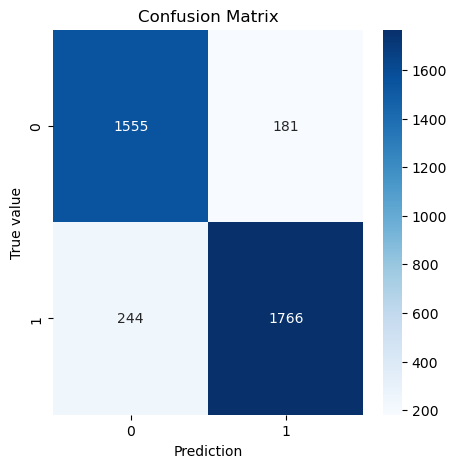

In [51]:
plot_confusion(confusion_matrix(y_test, y_pred_lr_tf))

<h3>Predikcija novih ulaza</h3>

In [52]:
tweet = '''RT @ColdHearted: Absolutely loved the new movie! The storyline was captivating, the acting was superb,
and the visuals were stunning... Highly recommend it! #movie #entertainment'''

In [53]:
def predict_tweet(tweet):
    
    processed_tweet = process_tweet(tweet)
    transformed_tweet = tf.transform([processed_tweet])
    pred = model_lr_tf.predict(transformed_tweet)
    if pred == 1:
        return "1"
    else:
        return "0"

In [54]:
predict_tweet(tweet)

'1'